<a href="https://colab.research.google.com/github/Anta2104/Bomberman_game/blob/main/Detection_kangaroo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Aug 27 13:48:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# split into train and test set
import sys
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray

from mrcnn.utils import Dataset


# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir('/content/drive/MyDrive/kangaroo/images'):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))



Train: 131
Test: 32


In [14]:
# plot one photograph and mask
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir('/content/drive/MyDrive/kangaroo/images'):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']



In [5]:
from mrcnn.config import Config

class KangarooConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131

In [ ]:
from tensorflow import keras 
from mrcnn.model import MaskRCNN
# prepare train set
train_set = KangarooDataset()
train_set.load_dataset('/content/drive/MyDrive/kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = KangarooDataset()
test_set.load_dataset('/content/drive/MyDrive/kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = KangarooConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('/content/drive/MyDrive/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
#model.fit(train_set,test_set)

model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Train: 131
Test: 32

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_4/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier_4/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier_4/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shap

  1/131 [..............................] - ETA: 1:36:59 - batch: 0.0000e+00 - size: 2.0000 - loss: 57.4894 - rpn_class_loss: 47.4492 - rpn_bbox_loss: 10.0402 - mrcnn_class_loss: 1.7881e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/131 [..............................] - ETA: 6:35 - batch: 0.5000 - size: 2.0000 - loss: 51.1572 - rpn_class_loss: 38.3128 - rpn_bbox_loss: 10.3531 - mrcnn_class_loss: 1.6558e-06 - mrcnn_bbox_loss: 2.1054 - mrcnn_mask_loss: 0.3859               

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 4:12 - batch: 1.0000 - size: 2.0000 - loss: 36.8395 - rpn_class_loss: 26.5363 - rpn_bbox_loss: 8.6423 - mrcnn_class_loss: 1.5012e-06 - mrcnn_bbox_loss: 1.4036 - mrcnn_mask_loss: 0.2573 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 3:26 - batch: 1.5000 - size: 2.0000 - loss: 29.7399 - rpn_class_loss: 19.9947 - rpn_bbox_loss: 7.7535 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 1.5740 - mrcnn_mask_loss: 0.4038    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/131 [>.............................] - ETA: 3:01 - batch: 2.0000 - size: 2.0000 - loss: 25.2585 - rpn_class_loss: 16.0406 - rpn_bbox_loss: 7.0959 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 1.6160 - mrcnn_mask_loss: 0.4686

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:46 - batch: 2.5000 - size: 2.0000 - loss: 23.2060 - rpn_class_loss: 13.3777 - rpn_bbox_loss: 6.8718 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 2.4245 - mrcnn_mask_loss: 0.4999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:36 - batch: 3.0000 - size: 2.0000 - loss: 21.1943 - rpn_class_loss: 11.4762 - rpn_bbox_loss: 6.6280 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 2.5532 - mrcnn_mask_loss: 0.5090

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/131 [>.............................] - ETA: 2:29 - batch: 3.5000 - size: 2.0000 - loss: 19.9605 - rpn_class_loss: 10.0667 - rpn_bbox_loss: 6.4630 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 2.8467 - mrcnn_mask_loss: 0.5596

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:23 - batch: 4.0000 - size: 2.0000 - loss: 18.7203 - rpn_class_loss: 8.9557 - rpn_bbox_loss: 6.3520 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 2.8306 - mrcnn_mask_loss: 0.5582 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:19 - batch: 4.5000 - size: 2.0000 - loss: 17.8886 - rpn_class_loss: 8.0799 - rpn_bbox_loss: 6.2529 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 2.9735 - mrcnn_mask_loss: 0.5585

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:14 - batch: 5.0000 - size: 2.0000 - loss: 17.2058 - rpn_class_loss: 7.3507 - rpn_bbox_loss: 6.3319 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 2.9322 - mrcnn_mask_loss: 0.5621

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:11 - batch: 5.5000 - size: 2.0000 - loss: 16.4426 - rpn_class_loss: 6.7428 - rpn_bbox_loss: 6.2442 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 2.8601 - mrcnn_mask_loss: 0.5656

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:08 - batch: 6.0000 - size: 2.0000 - loss: 16.0061 - rpn_class_loss: 6.2311 - rpn_bbox_loss: 6.2521 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 2.9153 - mrcnn_mask_loss: 0.5628

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:06 - batch: 6.5000 - size: 2.0000 - loss: 15.7699 - rpn_class_loss: 5.7883 - rpn_bbox_loss: 6.3356 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 3.0388 - mrcnn_mask_loss: 0.5656

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/131 [==>...........................] - ETA: 2:03 - batch: 7.0000 - size: 2.0000 - loss: 15.5057 - rpn_class_loss: 5.4093 - rpn_bbox_loss: 6.5047 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 2.9864 - mrcnn_mask_loss: 0.5654

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:01 - batch: 7.5000 - size: 2.0000 - loss: 15.6496 - rpn_class_loss: 5.1543 - rpn_bbox_loss: 6.9690 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 2.9270 - mrcnn_mask_loss: 0.5619

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:59 - batch: 8.0000 - size: 2.0000 - loss: 15.9234 - rpn_class_loss: 4.9713 - rpn_bbox_loss: 7.4561 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 2.8995 - mrcnn_mask_loss: 0.5611

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:57 - batch: 8.5000 - size: 2.0000 - loss: 15.7061 - rpn_class_loss: 4.7010 - rpn_bbox_loss: 7.5771 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 2.8242 - mrcnn_mask_loss: 0.5702

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:55 - batch: 9.0000 - size: 2.0000 - loss: 15.8195 - rpn_class_loss: 4.6573 - rpn_bbox_loss: 7.7239 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 2.8352 - mrcnn_mask_loss: 0.5705

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:54 - batch: 9.5000 - size: 2.0000 - loss: 15.4865 - rpn_class_loss: 4.4255 - rpn_bbox_loss: 7.6301 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 2.8276 - mrcnn_mask_loss: 0.5716

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 59s - batch: 32.5000 - size: 2.0000 - loss: 10.4614 - rpn_class_loss: 1.4919 - rpn_bbox_loss: 5.5866 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 2.8181 - mrcnn_mask_loss: 0.5101 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 67/131 [==============>...............] - ETA: 1:00 - batch: 33.0000 - size: 2.0000 - loss: 10.3626 - rpn_class_loss: 1.4716 - rpn_bbox_loss: 5.5248 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 2.8013 - mrcnn_mask_loss: 0.5105

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 68/131 [==============>...............] - ETA: 59s - batch: 33.5000 - size: 2.0000 - loss: 10.2531 - rpn_class_loss: 1.4520 - rpn_bbox_loss: 5.4595 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 2.7761 - mrcnn_mask_loss: 0.5106 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 69/131 [==============>...............] - ETA: 58s - batch: 34.0000 - size: 2.0000 - loss: 10.1760 - rpn_class_loss: 1.4315 - rpn_bbox_loss: 5.4268 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 2.7515 - mrcnn_mask_loss: 0.5109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 70/131 [===============>..............] - ETA: 57s - batch: 34.5000 - size: 2.0000 - loss: 10.0987 - rpn_class_loss: 1.4115 - rpn_bbox_loss: 5.3942 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 2.7249 - mrcnn_mask_loss: 0.5117

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 71/131 [===============>..............] - ETA: 56s - batch: 35.0000 - size: 2.0000 - loss: 9.9988 - rpn_class_loss: 1.3923 - rpn_bbox_loss: 5.3400 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 2.6962 - mrcnn_mask_loss: 0.5129 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 72/131 [===============>..............] - ETA: 55s - batch: 35.5000 - size: 2.0000 - loss: 9.8942 - rpn_class_loss: 1.3736 - rpn_bbox_loss: 5.2822 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 2.6672 - mrcnn_mask_loss: 0.5138

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 73/131 [===============>..............] - ETA: 55s - batch: 36.0000 - size: 2.0000 - loss: 9.8273 - rpn_class_loss: 1.3552 - rpn_bbox_loss: 5.2378 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 2.6633 - mrcnn_mask_loss: 0.5136

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 74/131 [===============>..............] - ETA: 54s - batch: 36.5000 - size: 2.0000 - loss: 9.7343 - rpn_class_loss: 1.3372 - rpn_bbox_loss: 5.1829 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 2.6429 - mrcnn_mask_loss: 0.5137

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 75/131 [================>.............] - ETA: 53s - batch: 37.0000 - size: 2.0000 - loss: 9.6409 - rpn_class_loss: 1.3204 - rpn_bbox_loss: 5.1284 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 2.6213 - mrcnn_mask_loss: 0.5132

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 76/131 [================>.............] - ETA: 52s - batch: 37.5000 - size: 2.0000 - loss: 9.5526 - rpn_class_loss: 1.3039 - rpn_bbox_loss: 5.0727 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 2.6025 - mrcnn_mask_loss: 0.5127

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 77/131 [================>.............] - ETA: 51s - batch: 38.0000 - size: 2.0000 - loss: 9.4919 - rpn_class_loss: 1.2873 - rpn_bbox_loss: 5.0470 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 2.5824 - mrcnn_mask_loss: 0.5131

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 78/131 [================>.............] - ETA: 50s - batch: 38.5000 - size: 2.0000 - loss: 9.4350 - rpn_class_loss: 1.2712 - rpn_bbox_loss: 5.0191 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 2.5667 - mrcnn_mask_loss: 0.5138

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 79/131 [=================>............] - ETA: 49s - batch: 39.0000 - size: 2.0000 - loss: 9.3615 - rpn_class_loss: 1.2556 - rpn_bbox_loss: 4.9705 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 2.5549 - mrcnn_mask_loss: 0.5134

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 80/131 [=================>............] - ETA: 48s - batch: 39.5000 - size: 2.0000 - loss: 9.2804 - rpn_class_loss: 1.2405 - rpn_bbox_loss: 4.9220 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 2.5374 - mrcnn_mask_loss: 0.5130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 81/131 [=================>............] - ETA: 47s - batch: 40.0000 - size: 2.0000 - loss: 9.2069 - rpn_class_loss: 1.2259 - rpn_bbox_loss: 4.8827 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 2.5175 - mrcnn_mask_loss: 0.5130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 46s - batch: 40.5000 - size: 2.0000 - loss: 9.1340 - rpn_class_loss: 1.2117 - rpn_bbox_loss: 4.8390 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 2.5022 - mrcnn_mask_loss: 0.5128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 83/131 [==================>...........] - ETA: 45s - batch: 41.0000 - size: 2.0000 - loss: 9.0699 - rpn_class_loss: 1.1975 - rpn_bbox_loss: 4.8044 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 2.4847 - mrcnn_mask_loss: 0.5129

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 84/131 [==================>...........] - ETA: 44s - batch: 41.5000 - size: 2.0000 - loss: 9.0007 - rpn_class_loss: 1.1836 - rpn_bbox_loss: 4.7683 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 2.4647 - mrcnn_mask_loss: 0.5126

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 85/131 [==================>...........] - ETA: 43s - batch: 42.0000 - size: 2.0000 - loss: 8.9370 - rpn_class_loss: 1.1703 - rpn_bbox_loss: 4.7362 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 2.4470 - mrcnn_mask_loss: 0.5122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 86/131 [==================>...........] - ETA: 42s - batch: 42.5000 - size: 2.0000 - loss: 8.8708 - rpn_class_loss: 1.1571 - rpn_bbox_loss: 4.7034 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 2.4265 - mrcnn_mask_loss: 0.5119

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 87/131 [==================>...........] - ETA: 41s - batch: 43.0000 - size: 2.0000 - loss: 8.8096 - rpn_class_loss: 1.1443 - rpn_bbox_loss: 4.6637 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 2.4118 - mrcnn_mask_loss: 0.5115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 88/131 [===================>..........] - ETA: 40s - batch: 43.5000 - size: 2.0000 - loss: 8.7457 - rpn_class_loss: 1.1318 - rpn_bbox_loss: 4.6204 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 2.3958 - mrcnn_mask_loss: 0.5109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 89/131 [===================>..........] - ETA: 39s - batch: 44.0000 - size: 2.0000 - loss: 8.6714 - rpn_class_loss: 1.1194 - rpn_bbox_loss: 4.5760 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 2.3775 - mrcnn_mask_loss: 0.5106

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 38s - batch: 44.5000 - size: 2.0000 - loss: 8.5963 - rpn_class_loss: 1.1073 - rpn_bbox_loss: 4.5307 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 2.3589 - mrcnn_mask_loss: 0.5102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 91/131 [===================>..........] - ETA: 38s - batch: 45.0000 - size: 2.0000 - loss: 8.5489 - rpn_class_loss: 1.0962 - rpn_bbox_loss: 4.5048 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 2.3471 - mrcnn_mask_loss: 0.5098

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 92/131 [====================>.........] - ETA: 37s - batch: 45.5000 - size: 2.0000 - loss: 8.4967 - rpn_class_loss: 1.0853 - rpn_bbox_loss: 4.4746 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 2.3340 - mrcnn_mask_loss: 0.5095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 93/131 [====================>.........] - ETA: 36s - batch: 46.0000 - size: 2.0000 - loss: 8.4461 - rpn_class_loss: 1.0739 - rpn_bbox_loss: 4.4444 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 2.3248 - mrcnn_mask_loss: 0.5095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 94/131 [====================>.........] - ETA: 35s - batch: 46.5000 - size: 2.0000 - loss: 8.3898 - rpn_class_loss: 1.0626 - rpn_bbox_loss: 4.4112 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 2.3123 - mrcnn_mask_loss: 0.5087

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 95/131 [====================>.........] - ETA: 34s - batch: 47.0000 - size: 2.0000 - loss: 8.3476 - rpn_class_loss: 1.0518 - rpn_bbox_loss: 4.3874 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 2.3008 - mrcnn_mask_loss: 0.5084

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 96/131 [====================>.........] - ETA: 33s - batch: 47.5000 - size: 2.0000 - loss: 8.3026 - rpn_class_loss: 1.0411 - rpn_bbox_loss: 4.3616 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 2.2887 - mrcnn_mask_loss: 0.5081

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 97/131 [=====================>........] - ETA: 32s - batch: 48.0000 - size: 2.0000 - loss: 8.2594 - rpn_class_loss: 1.0358 - rpn_bbox_loss: 4.3352 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 2.2778 - mrcnn_mask_loss: 0.5080

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 98/131 [=====================>........] - ETA: 31s - batch: 48.5000 - size: 2.0000 - loss: 8.2167 - rpn_class_loss: 1.0302 - rpn_bbox_loss: 4.3096 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 2.2663 - mrcnn_mask_loss: 0.5080

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 99/131 [=====================>........] - ETA: 30s - batch: 49.0000 - size: 2.0000 - loss: 8.2289 - rpn_class_loss: 1.0280 - rpn_bbox_loss: 4.3215 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 2.2669 - mrcnn_mask_loss: 0.5088

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/131 [=====================>........] - ETA: 29s - batch: 49.5000 - size: 2.0000 - loss: 8.2097 - rpn_class_loss: 1.0255 - rpn_bbox_loss: 4.3200 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 2.2524 - mrcnn_mask_loss: 0.5088

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

101/131 [======================>.......] - ETA: 28s - batch: 50.0000 - size: 2.0000 - loss: 8.1622 - rpn_class_loss: 1.0164 - rpn_bbox_loss: 4.2904 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 2.2430 - mrcnn_mask_loss: 0.5087

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/131 [==============================] - ETA: 0s - batch: 65.0000 - size: 2.0000 - loss: 7.3453 - rpn_class_loss: 0.8122 - rpn_bbox_loss: 3.9154 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 2.0070 - mrcnn_mask_loss: 0.5026

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 292s 2s/step - batch: 65.0000 - size: 2.0000 - loss: 7.3453 - rpn_class_loss: 0.8122 - rpn_bbox_loss: 3.9154 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 2.0070 - mrcnn_mask_loss: 0.5026 - val_loss: 3.9697 - val_rpn_class_loss: 0.1225 - val_rpn_bbox_loss: 1.9275 - val_mrcnn_class_loss: 0.1634 - val_mrcnn_bbox_loss: 1.2695 - val_mrcnn_mask_loss: 0.4868
Epoch 2/5
  1/131 [..............................] - ETA: 2:26 - batch: 0.0000e+00 - size: 2.0000 - loss: 2.8261 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.5300 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.7785 - mrcnn_mask_loss: 0.4420

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/131 [..............................] - ETA: 4:35 - batch: 0.5000 - size: 2.0000 - loss: 3.0873 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.3167 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 1.0920 - mrcnn_mask_loss: 0.5318    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/131 [..............................] - ETA: 3:15 - batch: 1.0000 - size: 2.0000 - loss: 3.0144 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.1804 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 1.1612 - mrcnn_mask_loss: 0.5130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/131 [..............................] - ETA: 2:47 - batch: 1.5000 - size: 2.0000 - loss: 2.7852 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 1.0216 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 1.1078 - mrcnn_mask_loss: 0.5205

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/131 [>.............................] - ETA: 2:34 - batch: 2.0000 - size: 2.0000 - loss: 2.8812 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.1349 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 1.1058 - mrcnn_mask_loss: 0.5055

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/131 [>.............................] - ETA: 2:25 - batch: 2.5000 - size: 2.0000 - loss: 2.7471 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 1.0374 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 1.0576 - mrcnn_mask_loss: 0.5128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/131 [>.............................] - ETA: 2:19 - batch: 3.0000 - size: 2.0000 - loss: 2.7072 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 1.0102 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 1.0460 - mrcnn_mask_loss: 0.5014

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/131 [>.............................] - ETA: 2:15 - batch: 3.5000 - size: 2.0000 - loss: 2.6893 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.9893 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 1.0450 - mrcnn_mask_loss: 0.5019

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/131 [=>............................] - ETA: 2:11 - batch: 4.0000 - size: 2.0000 - loss: 2.6950 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.9807 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 1.0477 - mrcnn_mask_loss: 0.4982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:08 - batch: 4.5000 - size: 2.0000 - loss: 2.6420 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.9728 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 1.0064 - mrcnn_mask_loss: 0.4959

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/131 [=>............................] - ETA: 2:05 - batch: 5.0000 - size: 2.0000 - loss: 2.5747 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.9571 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.9606 - mrcnn_mask_loss: 0.4918

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:03 - batch: 5.5000 - size: 2.0000 - loss: 2.5686 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.9527 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.9596 - mrcnn_mask_loss: 0.4903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/131 [=>............................] - ETA: 2:00 - batch: 6.0000 - size: 2.0000 - loss: 2.5269 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.9362 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.9431 - mrcnn_mask_loss: 0.4884

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/131 [==>...........................] - ETA: 1:58 - batch: 6.5000 - size: 2.0000 - loss: 2.5193 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.9272 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.9358 - mrcnn_mask_loss: 0.4886

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/131 [==>...........................] - ETA: 1:57 - batch: 7.0000 - size: 2.0000 - loss: 2.5490 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.9648 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.9291 - mrcnn_mask_loss: 0.4877

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/131 [==>...........................] - ETA: 1:55 - batch: 7.5000 - size: 2.0000 - loss: 2.5508 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.9621 - mrcnn_class_loss: 0.1434 - mrcnn_bbox_loss: 0.9183 - mrcnn_mask_loss: 0.4873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:53 - batch: 8.0000 - size: 2.0000 - loss: 2.5917 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.9975 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.9198 - mrcnn_mask_loss: 0.4852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/131 [===>..........................] - ETA: 1:52 - batch: 8.5000 - size: 2.0000 - loss: 2.7833 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.1235 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.9373 - mrcnn_mask_loss: 0.4889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:51 - batch: 9.0000 - size: 2.0000 - loss: 2.7756 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.1155 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.9314 - mrcnn_mask_loss: 0.4889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/131 [===>..........................] - ETA: 1:49 - batch: 9.5000 - size: 2.0000 - loss: 2.8950 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 1.2090 - mrcnn_class_loss: 0.1675 - mrcnn_bbox_loss: 0.9441 - mrcnn_mask_loss: 0.4887

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:48 - batch: 10.0000 - size: 2.0000 - loss: 2.8673 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.1810 - mrcnn_class_loss: 0.1673 - mrcnn_bbox_loss: 0.9483 - mrcnn_mask_loss: 0.4875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/131 [====>.........................] - ETA: 1:47 - batch: 10.5000 - size: 2.0000 - loss: 2.8332 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.1670 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.9338 - mrcnn_mask_loss: 0.4863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/131 [====>.........................] - ETA: 1:46 - batch: 11.0000 - size: 2.0000 - loss: 3.0070 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.3367 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.9345 - mrcnn_mask_loss: 0.4848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 24/131 [====>.........................] - ETA: 1:44 - batch: 11.5000 - size: 2.0000 - loss: 3.0234 - rpn_class_loss: 0.0910 - rpn_bbox_loss: 1.3410 - mrcnn_class_loss: 0.1731 - mrcnn_bbox_loss: 0.9323 - mrcnn_mask_loss: 0.4860

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 25/131 [====>.........................] - ETA: 1:43 - batch: 12.0000 - size: 2.0000 - loss: 3.0063 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 1.3317 - mrcnn_class_loss: 0.1704 - mrcnn_bbox_loss: 0.9281 - mrcnn_mask_loss: 0.4847

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 26/131 [====>.........................] - ETA: 1:42 - batch: 12.5000 - size: 2.0000 - loss: 2.9849 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 1.3140 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.9219 - mrcnn_mask_loss: 0.4851

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 27/131 [=====>........................] - ETA: 1:41 - batch: 13.0000 - size: 2.0000 - loss: 2.9571 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.2990 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.9155 - mrcnn_mask_loss: 0.4821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 28/131 [=====>........................] - ETA: 1:40 - batch: 13.5000 - size: 2.0000 - loss: 2.9373 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 1.2805 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.9156 - mrcnn_mask_loss: 0.4826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 29/131 [=====>........................] - ETA: 1:39 - batch: 14.0000 - size: 2.0000 - loss: 2.8974 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 1.2513 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.9111 - mrcnn_mask_loss: 0.4813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:38 - batch: 14.5000 - size: 2.0000 - loss: 2.8642 - rpn_class_loss: 0.0847 - rpn_bbox_loss: 1.2265 - mrcnn_class_loss: 0.1644 - mrcnn_bbox_loss: 0.9086 - mrcnn_mask_loss: 0.4800

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 31/131 [======>.......................] - ETA: 1:37 - batch: 15.0000 - size: 2.0000 - loss: 2.8642 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 1.2274 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.9041 - mrcnn_mask_loss: 0.4795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 32/131 [======>.......................] - ETA: 1:36 - batch: 15.5000 - size: 2.0000 - loss: 2.8513 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.2206 - mrcnn_class_loss: 0.1688 - mrcnn_bbox_loss: 0.8997 - mrcnn_mask_loss: 0.4789

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 33/131 [======>.......................] - ETA: 1:34 - batch: 16.0000 - size: 2.0000 - loss: 2.8267 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 1.2090 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.8930 - mrcnn_mask_loss: 0.4768

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 34/131 [======>.......................] - ETA: 1:33 - batch: 16.5000 - size: 2.0000 - loss: 2.7959 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.1943 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.8830 - mrcnn_mask_loss: 0.4751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 35/131 [=======>......................] - ETA: 1:32 - batch: 17.0000 - size: 2.0000 - loss: 2.7678 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.1775 - mrcnn_class_loss: 0.1608 - mrcnn_bbox_loss: 0.8761 - mrcnn_mask_loss: 0.4752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 36/131 [=======>......................] - ETA: 1:31 - batch: 17.5000 - size: 2.0000 - loss: 2.7320 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 1.1599 - mrcnn_class_loss: 0.1574 - mrcnn_bbox_loss: 0.8635 - mrcnn_mask_loss: 0.4745

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 37/131 [=======>......................] - ETA: 1:30 - batch: 18.0000 - size: 2.0000 - loss: 2.7192 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.1532 - mrcnn_class_loss: 0.1559 - mrcnn_bbox_loss: 0.8611 - mrcnn_mask_loss: 0.4731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 38/131 [=======>......................] - ETA: 1:29 - batch: 18.5000 - size: 2.0000 - loss: 2.7178 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.1540 - mrcnn_class_loss: 0.1542 - mrcnn_bbox_loss: 0.8589 - mrcnn_mask_loss: 0.4748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 39/131 [=======>......................] - ETA: 1:28 - batch: 19.0000 - size: 2.0000 - loss: 2.6993 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.1401 - mrcnn_class_loss: 0.1526 - mrcnn_bbox_loss: 0.8567 - mrcnn_mask_loss: 0.4747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 40/131 [========>.....................] - ETA: 1:27 - batch: 19.5000 - size: 2.0000 - loss: 2.6960 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.1433 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.8542 - mrcnn_mask_loss: 0.4741

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 41/131 [========>.....................] - ETA: 1:26 - batch: 20.0000 - size: 2.0000 - loss: 2.6746 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.1288 - mrcnn_class_loss: 0.1480 - mrcnn_bbox_loss: 0.8506 - mrcnn_mask_loss: 0.4735

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 42/131 [========>.....................] - ETA: 1:25 - batch: 20.5000 - size: 2.0000 - loss: 2.7045 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 1.1686 - mrcnn_class_loss: 0.1456 - mrcnn_bbox_loss: 0.8434 - mrcnn_mask_loss: 0.4724

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 43/131 [========>.....................] - ETA: 1:24 - batch: 21.0000 - size: 2.0000 - loss: 2.7514 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.2028 - mrcnn_class_loss: 0.1456 - mrcnn_bbox_loss: 0.8489 - mrcnn_mask_loss: 0.4742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:23 - batch: 21.5000 - size: 2.0000 - loss: 2.7364 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.1945 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.8456 - mrcnn_mask_loss: 0.4730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 45/131 [=========>....................] - ETA: 1:22 - batch: 22.0000 - size: 2.0000 - loss: 2.7177 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.1817 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.8435 - mrcnn_mask_loss: 0.4713

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 67/131 [==============>...............] - ETA: 1:00 - batch: 33.0000 - size: 2.0000 - loss: 2.5917 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.0694 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.8489 - mrcnn_mask_loss: 0.4639

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 68/131 [==============>...............] - ETA: 1:00 - batch: 33.5000 - size: 2.0000 - loss: 2.5857 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.0651 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.8472 - mrcnn_mask_loss: 0.4648

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 69/131 [==============>...............] - ETA: 59s - batch: 34.0000 - size: 2.0000 - loss: 2.5769 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.0584 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.8461 - mrcnn_mask_loss: 0.4645 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 70/131 [===============>..............] - ETA: 58s - batch: 34.5000 - size: 2.0000 - loss: 2.5737 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.0533 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.8488 - mrcnn_mask_loss: 0.4650

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 71/131 [===============>..............] - ETA: 57s - batch: 35.0000 - size: 2.0000 - loss: 2.5654 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.0468 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.8473 - mrcnn_mask_loss: 0.4658

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 72/131 [===============>..............] - ETA: 56s - batch: 35.5000 - size: 2.0000 - loss: 2.5540 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.0384 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.8459 - mrcnn_mask_loss: 0.4663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 73/131 [===============>..............] - ETA: 55s - batch: 36.0000 - size: 2.0000 - loss: 2.5410 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.0297 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.8437 - mrcnn_mask_loss: 0.4662

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 74/131 [===============>..............] - ETA: 54s - batch: 36.5000 - size: 2.0000 - loss: 2.5369 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.0260 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.8438 - mrcnn_mask_loss: 0.4667

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 75/131 [================>.............] - ETA: 53s - batch: 37.0000 - size: 2.0000 - loss: 2.5289 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.0192 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.8438 - mrcnn_mask_loss: 0.4670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 76/131 [================>.............] - ETA: 52s - batch: 37.5000 - size: 2.0000 - loss: 2.5262 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.0202 - mrcnn_class_loss: 0.1343 - mrcnn_bbox_loss: 0.8415 - mrcnn_mask_loss: 0.4670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 77/131 [================>.............] - ETA: 51s - batch: 38.0000 - size: 2.0000 - loss: 2.5241 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.0200 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.8413 - mrcnn_mask_loss: 0.4668

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 78/131 [================>.............] - ETA: 51s - batch: 38.5000 - size: 2.0000 - loss: 2.5279 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.0234 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.8419 - mrcnn_mask_loss: 0.4683

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 79/131 [=================>............] - ETA: 50s - batch: 39.0000 - size: 2.0000 - loss: 2.5252 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.0209 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.8429 - mrcnn_mask_loss: 0.4684

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 80/131 [=================>............] - ETA: 49s - batch: 39.5000 - size: 2.0000 - loss: 2.5229 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.0207 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.8422 - mrcnn_mask_loss: 0.4683

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 81/131 [=================>............] - ETA: 48s - batch: 40.0000 - size: 2.0000 - loss: 2.5169 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.0180 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.8400 - mrcnn_mask_loss: 0.4679

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 82/131 [=================>............] - ETA: 47s - batch: 40.5000 - size: 2.0000 - loss: 2.5082 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.0125 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.8376 - mrcnn_mask_loss: 0.4675

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 46s - batch: 41.0000 - size: 2.0000 - loss: 2.4986 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.0071 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.8347 - mrcnn_mask_loss: 0.4674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 84/131 [==================>...........] - ETA: 45s - batch: 41.5000 - size: 2.0000 - loss: 2.4918 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.0022 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.8334 - mrcnn_mask_loss: 0.4676

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 85/131 [==================>...........] - ETA: 44s - batch: 42.0000 - size: 2.0000 - loss: 2.4822 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 0.9973 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.8298 - mrcnn_mask_loss: 0.4675

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 86/131 [==================>...........] - ETA: 43s - batch: 42.5000 - size: 2.0000 - loss: 2.4705 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 0.9903 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.8265 - mrcnn_mask_loss: 0.4675

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 87/131 [==================>...........] - ETA: 42s - batch: 43.0000 - size: 2.0000 - loss: 2.4570 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 0.9820 - mrcnn_class_loss: 0.1271 - mrcnn_bbox_loss: 0.8226 - mrcnn_mask_loss: 0.4674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 88/131 [===================>..........] - ETA: 41s - batch: 43.5000 - size: 2.0000 - loss: 2.4507 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 0.9762 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.8223 - mrcnn_mask_loss: 0.4671

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 89/131 [===================>..........] - ETA: 40s - batch: 44.0000 - size: 2.0000 - loss: 2.4409 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 0.9702 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.8193 - mrcnn_mask_loss: 0.4664

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 90/131 [===================>..........] - ETA: 39s - batch: 44.5000 - size: 2.0000 - loss: 2.4283 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 0.9627 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.8159 - mrcnn_mask_loss: 0.4663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 91/131 [===================>..........] - ETA: 38s - batch: 45.0000 - size: 2.0000 - loss: 2.4139 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 0.9537 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.8118 - mrcnn_mask_loss: 0.4664

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 92/131 [====================>.........] - ETA: 37s - batch: 45.5000 - size: 2.0000 - loss: 2.4143 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 0.9539 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.8126 - mrcnn_mask_loss: 0.4660

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 93/131 [====================>.........] - ETA: 36s - batch: 46.0000 - size: 2.0000 - loss: 2.4146 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.9535 - mrcnn_class_loss: 0.1262 - mrcnn_bbox_loss: 0.8139 - mrcnn_mask_loss: 0.4653

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 94/131 [====================>.........] - ETA: 35s - batch: 46.5000 - size: 2.0000 - loss: 2.4163 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 0.9525 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.8169 - mrcnn_mask_loss: 0.4651

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 95/131 [====================>.........] - ETA: 34s - batch: 47.0000 - size: 2.0000 - loss: 2.4091 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 0.9471 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.8154 - mrcnn_mask_loss: 0.4649

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 96/131 [====================>.........] - ETA: 33s - batch: 47.5000 - size: 2.0000 - loss: 2.4085 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 0.9447 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.8157 - mrcnn_mask_loss: 0.4657

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 97/131 [=====================>........] - ETA: 32s - batch: 48.0000 - size: 2.0000 - loss: 2.4064 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.9421 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.8158 - mrcnn_mask_loss: 0.4659

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 98/131 [=====================>........] - ETA: 31s - batch: 48.5000 - size: 2.0000 - loss: 2.4135 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.9474 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.8161 - mrcnn_mask_loss: 0.4663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 99/131 [=====================>........] - ETA: 30s - batch: 49.0000 - size: 2.0000 - loss: 2.4123 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.9461 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.8152 - mrcnn_mask_loss: 0.4664

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/131 [=====================>........] - ETA: 29s - batch: 49.5000 - size: 2.0000 - loss: 2.4418 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 0.9724 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.8153 - mrcnn_mask_loss: 0.4671

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

101/131 [======================>.......] - ETA: 28s - batch: 50.0000 - size: 2.0000 - loss: 2.4613 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.9916 - mrcnn_class_loss: 0.1274 - mrcnn_bbox_loss: 0.8137 - mrcnn_mask_loss: 0.4672

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - ETA: 0s - batch: 65.0000 - size: 2.0000 - loss: 2.4651 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.9909 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.8192 - mrcnn_mask_loss: 0.4659

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 164s 1s/step - batch: 65.0000 - size: 2.0000 - loss: 2.4651 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.9909 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.8192 - mrcnn_mask_loss: 0.4659 - val_loss: 2.6233 - val_rpn_class_loss: 0.0677 - val_rpn_bbox_loss: 0.9965 - val_mrcnn_class_loss: 0.1093 - val_mrcnn_bbox_loss: 0.9701 - val_mrcnn_mask_loss: 0.4797
Epoch 3/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/131 [..............................] - ETA: 2:11 - batch: 0.0000e+00 - size: 2.0000 - loss: 1.5982 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.5965 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.5113 - mrcnn_mask_loss: 0.3804

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/131 [..............................] - ETA: 2:52 - batch: 0.5000 - size: 2.0000 - loss: 1.5020 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5152 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.5052 - mrcnn_mask_loss: 0.3792    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/131 [..............................] - ETA: 4:29 - batch: 1.0000 - size: 2.0000 - loss: 1.9615 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.7160 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.6882 - mrcnn_mask_loss: 0.4512

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/131 [..............................] - ETA: 3:39 - batch: 1.5000 - size: 2.0000 - loss: 2.0472 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.8099 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.6624 - mrcnn_mask_loss: 0.4687

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/131 [>.............................] - ETA: 3:13 - batch: 2.0000 - size: 2.0000 - loss: 2.2004 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 0.8625 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.7104 - mrcnn_mask_loss: 0.4999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/131 [>.............................] - ETA: 2:56 - batch: 2.5000 - size: 2.0000 - loss: 2.2906 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 0.8678 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.7586 - mrcnn_mask_loss: 0.5111

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/131 [>.............................] - ETA: 2:47 - batch: 3.0000 - size: 2.0000 - loss: 2.2674 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.8404 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.7761 - mrcnn_mask_loss: 0.5005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/131 [>.............................] - ETA: 2:38 - batch: 3.5000 - size: 2.0000 - loss: 2.2023 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.7966 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.7737 - mrcnn_mask_loss: 0.4888

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/131 [=>............................] - ETA: 2:32 - batch: 4.0000 - size: 2.0000 - loss: 2.2637 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.7598 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.8695 - mrcnn_mask_loss: 0.4943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/131 [=>............................] - ETA: 2:26 - batch: 4.5000 - size: 2.0000 - loss: 2.2729 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.7233 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.9228 - mrcnn_mask_loss: 0.4938

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/131 [=>............................] - ETA: 2:22 - batch: 5.0000 - size: 2.0000 - loss: 2.3334 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.7821 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.9198 - mrcnn_mask_loss: 0.4972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/131 [=>............................] - ETA: 2:18 - batch: 5.5000 - size: 2.0000 - loss: 2.3366 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.8179 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.8965 - mrcnn_mask_loss: 0.4914

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/131 [=>............................] - ETA: 2:15 - batch: 6.0000 - size: 2.0000 - loss: 2.3811 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.8562 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.9059 - mrcnn_mask_loss: 0.4942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/131 [==>...........................] - ETA: 2:12 - batch: 6.5000 - size: 2.0000 - loss: 2.3812 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.8597 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.9019 - mrcnn_mask_loss: 0.4937

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/131 [==>...........................] - ETA: 2:10 - batch: 7.0000 - size: 2.0000 - loss: 2.4015 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.8715 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.9019 - mrcnn_mask_loss: 0.4974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/131 [==>...........................] - ETA: 2:07 - batch: 7.5000 - size: 2.0000 - loss: 2.4065 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.8673 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.9046 - mrcnn_mask_loss: 0.4994

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/131 [==>...........................] - ETA: 2:05 - batch: 8.0000 - size: 2.0000 - loss: 2.4088 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.8758 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.8954 - mrcnn_mask_loss: 0.5020

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/131 [===>..........................] - ETA: 2:03 - batch: 8.5000 - size: 2.0000 - loss: 2.4061 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.8887 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.8751 - mrcnn_mask_loss: 0.5054

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/131 [===>..........................] - ETA: 2:01 - batch: 9.0000 - size: 2.0000 - loss: 2.4060 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.8984 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.8625 - mrcnn_mask_loss: 0.5080

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/131 [===>..........................] - ETA: 1:59 - batch: 9.5000 - size: 2.0000 - loss: 2.3967 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.8985 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.8516 - mrcnn_mask_loss: 0.5095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/131 [===>..........................] - ETA: 1:58 - batch: 10.0000 - size: 2.0000 - loss: 2.3987 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.9140 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.8413 - mrcnn_mask_loss: 0.5094

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/131 [====>.........................] - ETA: 1:56 - batch: 10.5000 - size: 2.0000 - loss: 2.3821 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.9103 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.8325 - mrcnn_mask_loss: 0.5085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/131 [====>.........................] - ETA: 1:55 - batch: 11.0000 - size: 2.0000 - loss: 2.3655 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.8940 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.8305 - mrcnn_mask_loss: 0.5073

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 24/131 [====>.........................] - ETA: 1:53 - batch: 11.5000 - size: 2.0000 - loss: 2.3367 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.8719 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.8223 - mrcnn_mask_loss: 0.5064

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 25/131 [====>.........................] - ETA: 1:52 - batch: 12.0000 - size: 2.0000 - loss: 2.3005 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.8510 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.8102 - mrcnn_mask_loss: 0.5050

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 26/131 [====>.........................] - ETA: 1:50 - batch: 12.5000 - size: 2.0000 - loss: 2.2644 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.8296 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.7995 - mrcnn_mask_loss: 0.5036

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 27/131 [=====>........................] - ETA: 1:49 - batch: 13.0000 - size: 2.0000 - loss: 2.2748 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.8328 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.8056 - mrcnn_mask_loss: 0.5011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 28/131 [=====>........................] - ETA: 1:47 - batch: 13.5000 - size: 2.0000 - loss: 2.2774 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.8326 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.8072 - mrcnn_mask_loss: 0.4995

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 29/131 [=====>........................] - ETA: 1:46 - batch: 14.0000 - size: 2.0000 - loss: 2.2699 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.8284 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.8051 - mrcnn_mask_loss: 0.4991

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 30/131 [=====>........................] - ETA: 1:45 - batch: 14.5000 - size: 2.0000 - loss: 2.2556 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.8163 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.8052 - mrcnn_mask_loss: 0.4969

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 31/131 [======>.......................] - ETA: 1:44 - batch: 15.0000 - size: 2.0000 - loss: 2.2588 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.8126 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.8105 - mrcnn_mask_loss: 0.4965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 32/131 [======>.......................] - ETA: 1:42 - batch: 15.5000 - size: 2.0000 - loss: 2.2555 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.8052 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.8123 - mrcnn_mask_loss: 0.4970

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 33/131 [======>.......................] - ETA: 1:41 - batch: 16.0000 - size: 2.0000 - loss: 2.3101 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.8527 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.8120 - mrcnn_mask_loss: 0.4995

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 34/131 [======>.......................] - ETA: 1:40 - batch: 16.5000 - size: 2.0000 - loss: 2.3312 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.8690 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.8105 - mrcnn_mask_loss: 0.5014

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 35/131 [=======>......................] - ETA: 1:38 - batch: 17.0000 - size: 2.0000 - loss: 2.5035 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.0317 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.8029 - mrcnn_mask_loss: 0.5089

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 36/131 [=======>......................] - ETA: 1:37 - batch: 17.5000 - size: 2.0000 - loss: 2.6346 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.1604 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.7954 - mrcnn_mask_loss: 0.5115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 37/131 [=======>......................] - ETA: 1:36 - batch: 18.0000 - size: 2.0000 - loss: 2.6190 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.1467 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.7957 - mrcnn_mask_loss: 0.5115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:00 - batch: 33.5000 - size: 2.0000 - loss: 2.5562 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.0699 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.8299 - mrcnn_mask_loss: 0.4980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 69/131 [==============>...............] - ETA: 1:00 - batch: 34.0000 - size: 2.0000 - loss: 2.5713 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.0668 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.8471 - mrcnn_mask_loss: 0.4992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 59s - batch: 34.5000 - size: 2.0000 - loss: 2.5629 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.0558 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.8482 - mrcnn_mask_loss: 0.5003 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 71/131 [===============>..............] - ETA: 58s - batch: 35.0000 - size: 2.0000 - loss: 2.5492 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.0470 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.8450 - mrcnn_mask_loss: 0.5001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 72/131 [===============>..............] - ETA: 57s - batch: 35.5000 - size: 2.0000 - loss: 2.5410 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.0383 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.8479 - mrcnn_mask_loss: 0.4982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 73/131 [===============>..............] - ETA: 56s - batch: 36.0000 - size: 2.0000 - loss: 2.5278 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.0285 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.8451 - mrcnn_mask_loss: 0.4981

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 55s - batch: 36.5000 - size: 2.0000 - loss: 2.5153 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.0202 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.8424 - mrcnn_mask_loss: 0.4971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 75/131 [================>.............] - ETA: 54s - batch: 37.0000 - size: 2.0000 - loss: 2.5138 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.0193 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.8414 - mrcnn_mask_loss: 0.4967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 76/131 [================>.............] - ETA: 53s - batch: 37.5000 - size: 2.0000 - loss: 2.5038 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.0124 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.8393 - mrcnn_mask_loss: 0.4958

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 77/131 [================>.............] - ETA: 52s - batch: 38.0000 - size: 2.0000 - loss: 2.4894 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.0040 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.8349 - mrcnn_mask_loss: 0.4950

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 78/131 [================>.............] - ETA: 51s - batch: 38.5000 - size: 2.0000 - loss: 2.4791 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.9978 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.8331 - mrcnn_mask_loss: 0.4937

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 50s - batch: 39.0000 - size: 2.0000 - loss: 2.4719 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 0.9906 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.8336 - mrcnn_mask_loss: 0.4932

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 80/131 [=================>............] - ETA: 49s - batch: 39.5000 - size: 2.0000 - loss: 2.4625 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.9839 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.8316 - mrcnn_mask_loss: 0.4933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 81/131 [=================>............] - ETA: 48s - batch: 40.0000 - size: 2.0000 - loss: 2.4537 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 0.9789 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.8290 - mrcnn_mask_loss: 0.4918

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 82/131 [=================>............] - ETA: 47s - batch: 40.5000 - size: 2.0000 - loss: 2.4475 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 0.9710 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.8324 - mrcnn_mask_loss: 0.4905

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 46s - batch: 41.0000 - size: 2.0000 - loss: 2.4423 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.9657 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.8309 - mrcnn_mask_loss: 0.4908

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 84/131 [==================>...........] - ETA: 45s - batch: 41.5000 - size: 2.0000 - loss: 2.4431 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.9651 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.8310 - mrcnn_mask_loss: 0.4910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 44s - batch: 42.0000 - size: 2.0000 - loss: 2.4495 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.9705 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.8301 - mrcnn_mask_loss: 0.4909

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 86/131 [==================>...........] - ETA: 43s - batch: 42.5000 - size: 2.0000 - loss: 2.4446 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 0.9662 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.8307 - mrcnn_mask_loss: 0.4906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 87/131 [==================>...........] - ETA: 42s - batch: 43.0000 - size: 2.0000 - loss: 2.4560 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.9771 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.8295 - mrcnn_mask_loss: 0.4903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 41s - batch: 43.5000 - size: 2.0000 - loss: 2.4494 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.9700 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.8311 - mrcnn_mask_loss: 0.4896

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 89/131 [===================>..........] - ETA: 40s - batch: 44.0000 - size: 2.0000 - loss: 2.4390 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.9611 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.8295 - mrcnn_mask_loss: 0.4906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 39s - batch: 44.5000 - size: 2.0000 - loss: 2.4427 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.9651 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.8301 - mrcnn_mask_loss: 0.4897

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 91/131 [===================>..........] - ETA: 38s - batch: 45.0000 - size: 2.0000 - loss: 2.4423 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.9623 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.8298 - mrcnn_mask_loss: 0.4898

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 37s - batch: 45.5000 - size: 2.0000 - loss: 2.4363 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.9592 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.8276 - mrcnn_mask_loss: 0.4889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 93/131 [====================>.........] - ETA: 36s - batch: 46.0000 - size: 2.0000 - loss: 2.4294 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.9546 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.8252 - mrcnn_mask_loss: 0.4886

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 35s - batch: 46.5000 - size: 2.0000 - loss: 2.4271 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.9535 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.8258 - mrcnn_mask_loss: 0.4873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 95/131 [====================>.........] - ETA: 34s - batch: 47.0000 - size: 2.0000 - loss: 2.4192 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.9466 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.8260 - mrcnn_mask_loss: 0.4863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 96/131 [====================>.........] - ETA: 33s - batch: 47.5000 - size: 2.0000 - loss: 2.4096 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.9392 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.8254 - mrcnn_mask_loss: 0.4855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 32s - batch: 48.0000 - size: 2.0000 - loss: 2.4016 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.9341 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.8230 - mrcnn_mask_loss: 0.4855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 98/131 [=====================>........] - ETA: 31s - batch: 48.5000 - size: 2.0000 - loss: 2.3963 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.9285 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.8230 - mrcnn_mask_loss: 0.4853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 99/131 [=====================>........] - ETA: 30s - batch: 49.0000 - size: 2.0000 - loss: 2.3941 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 0.9277 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.8222 - mrcnn_mask_loss: 0.4846

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/131 [=====================>........] - ETA: 29s - batch: 49.5000 - size: 2.0000 - loss: 2.3840 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.9212 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.8200 - mrcnn_mask_loss: 0.4839

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 28s - batch: 50.0000 - size: 2.0000 - loss: 2.3795 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.9194 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.8185 - mrcnn_mask_loss: 0.4837

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

102/131 [======================>.......] - ETA: 28s - batch: 50.5000 - size: 2.0000 - loss: 2.3731 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 0.9159 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.8164 - mrcnn_mask_loss: 0.4836

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

103/131 [======================>.......] - ETA: 27s - batch: 51.0000 - size: 2.0000 - loss: 2.3653 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 0.9103 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.8152 - mrcnn_mask_loss: 0.4833

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

104/131 [======================>.......] - ETA: 26s - batch: 51.5000 - size: 2.0000 - loss: 2.3596 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 0.9062 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.8144 - mrcnn_mask_loss: 0.4828

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

105/131 [=======================>......] - ETA: 25s - batch: 52.0000 - size: 2.0000 - loss: 2.3725 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.9188 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.8148 - mrcnn_mask_loss: 0.4824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

106/131 [=======================>......] - ETA: 24s - batch: 52.5000 - size: 2.0000 - loss: 2.3670 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.9154 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.8123 - mrcnn_mask_loss: 0.4821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

107/131 [=======================>......] - ETA: 23s - batch: 53.0000 - size: 2.0000 - loss: 2.3605 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.9111 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.8108 - mrcnn_mask_loss: 0.4817

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

108/131 [=======================>......] - ETA: 22s - batch: 53.5000 - size: 2.0000 - loss: 2.3569 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 0.9102 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.8086 - mrcnn_mask_loss: 0.4814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

109/131 [=======================>......] - ETA: 21s - batch: 54.0000 - size: 2.0000 - loss: 2.3849 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.9407 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.8070 - mrcnn_mask_loss: 0.4809

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 20s - batch: 54.5000 - size: 2.0000 - loss: 2.3915 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 0.9426 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.8100 - mrcnn_mask_loss: 0.4815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

111/131 [========================>.....] - ETA: 19s - batch: 55.0000 - size: 2.0000 - loss: 2.3842 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.9379 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.8084 - mrcnn_mask_loss: 0.4810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

112/131 [========================>.....] - ETA: 18s - batch: 55.5000 - size: 2.0000 - loss: 2.3798 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.9354 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.8070 - mrcnn_mask_loss: 0.4802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 17s - batch: 56.0000 - size: 2.0000 - loss: 2.3760 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 0.9332 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.8058 - mrcnn_mask_loss: 0.4791

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/131 [==============================] - ETA: 0s - batch: 65.0000 - size: 2.0000 - loss: 2.3221 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.8931 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.7975 - mrcnn_mask_loss: 0.4745

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 164s 1s/step - batch: 65.0000 - size: 2.0000 - loss: 2.3221 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.8931 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.7975 - mrcnn_mask_loss: 0.4745 - val_loss: 2.0585 - val_rpn_class_loss: 0.0698 - val_rpn_bbox_loss: 0.6945 - val_mrcnn_class_loss: 0.1446 - val_mrcnn_bbox_loss: 0.6444 - val_mrcnn_mask_loss: 0.5053
Epoch 4/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/131 [..............................] - ETA: 2:06 - batch: 0.0000e+00 - size: 2.0000 - loss: 1.9977 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.6704 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.7462 - mrcnn_mask_loss: 0.4889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/131 [..............................] - ETA: 2:04 - batch: 0.5000 - size: 2.0000 - loss: 2.0893 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.7381 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.7831 - mrcnn_mask_loss: 0.3989    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/131 [..............................] - ETA: 2:20 - batch: 1.0000 - size: 2.0000 - loss: 2.0060 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.6798 - mrcnn_class_loss: 0.1616 - mrcnn_bbox_loss: 0.7080 - mrcnn_mask_loss: 0.4229

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/131 [..............................] - ETA: 3:25 - batch: 1.5000 - size: 2.0000 - loss: 1.9841 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.6624 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.7338 - mrcnn_mask_loss: 0.4207

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/131 [>.............................] - ETA: 3:01 - batch: 2.0000 - size: 2.0000 - loss: 1.8715 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.5679 - mrcnn_class_loss: 0.1236 - mrcnn_bbox_loss: 0.7136 - mrcnn_mask_loss: 0.4332

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/131 [>.............................] - ETA: 2:46 - batch: 2.5000 - size: 2.0000 - loss: 1.8113 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.6937 - mrcnn_mask_loss: 0.4523

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/131 [>.............................] - ETA: 2:37 - batch: 3.0000 - size: 2.0000 - loss: 1.8482 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.5158 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.7481 - mrcnn_mask_loss: 0.4442

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/131 [>.............................] - ETA: 2:30 - batch: 3.5000 - size: 2.0000 - loss: 1.8272 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.7621 - mrcnn_mask_loss: 0.4488

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:24 - batch: 4.0000 - size: 2.0000 - loss: 1.7711 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.4583 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.7361 - mrcnn_mask_loss: 0.4465

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/131 [=>............................] - ETA: 2:19 - batch: 4.5000 - size: 2.0000 - loss: 1.8199 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.7415 - mrcnn_mask_loss: 0.4503

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/131 [=>............................] - ETA: 2:15 - batch: 5.0000 - size: 2.0000 - loss: 1.8156 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.4924 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.7398 - mrcnn_mask_loss: 0.4497

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/131 [=>............................] - ETA: 2:12 - batch: 5.5000 - size: 2.0000 - loss: 1.8027 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.4981 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.7203 - mrcnn_mask_loss: 0.4503

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:09 - batch: 6.0000 - size: 2.0000 - loss: 1.7744 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.4894 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.7065 - mrcnn_mask_loss: 0.4482

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/131 [==>...........................] - ETA: 2:06 - batch: 6.5000 - size: 2.0000 - loss: 1.7665 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.4810 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.7038 - mrcnn_mask_loss: 0.4449

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/131 [==>...........................] - ETA: 2:04 - batch: 7.0000 - size: 2.0000 - loss: 1.7519 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.7070 - mrcnn_mask_loss: 0.4421

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:02 - batch: 7.5000 - size: 2.0000 - loss: 1.7529 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.4684 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.7045 - mrcnn_mask_loss: 0.4428

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/131 [==>...........................] - ETA: 2:00 - batch: 8.0000 - size: 2.0000 - loss: 1.7578 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.4707 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.7062 - mrcnn_mask_loss: 0.4458

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/131 [===>..........................] - ETA: 1:58 - batch: 8.5000 - size: 2.0000 - loss: 1.7942 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.4887 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.7099 - mrcnn_mask_loss: 0.4551

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:56 - batch: 9.0000 - size: 2.0000 - loss: 1.8675 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.7150 - mrcnn_mask_loss: 0.4637

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:54 - batch: 9.5000 - size: 2.0000 - loss: 1.9809 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.6323 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.7256 - mrcnn_mask_loss: 0.4705

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/131 [===>..........................] - ETA: 1:53 - batch: 10.0000 - size: 2.0000 - loss: 2.0077 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.6491 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.7392 - mrcnn_mask_loss: 0.4695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/131 [====>.........................] - ETA: 1:51 - batch: 10.5000 - size: 2.0000 - loss: 2.1414 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 0.7706 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.7429 - mrcnn_mask_loss: 0.4680

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/131 [====>.........................] - ETA: 1:50 - batch: 11.0000 - size: 2.0000 - loss: 2.1410 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 0.7657 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.7490 - mrcnn_mask_loss: 0.4688

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 24/131 [====>.........................] - ETA: 1:49 - batch: 11.5000 - size: 2.0000 - loss: 2.1391 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 0.7657 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.7457 - mrcnn_mask_loss: 0.4720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 25/131 [====>.........................] - ETA: 1:47 - batch: 12.0000 - size: 2.0000 - loss: 2.1660 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.7722 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.7551 - mrcnn_mask_loss: 0.4731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 26/131 [====>.........................] - ETA: 1:46 - batch: 12.5000 - size: 2.0000 - loss: 2.2031 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.8046 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.7553 - mrcnn_mask_loss: 0.4744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 27/131 [=====>........................] - ETA: 1:45 - batch: 13.0000 - size: 2.0000 - loss: 2.1987 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 0.8044 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.7544 - mrcnn_mask_loss: 0.4729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 28/131 [=====>........................] - ETA: 1:43 - batch: 13.5000 - size: 2.0000 - loss: 2.1885 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.7966 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.7572 - mrcnn_mask_loss: 0.4704

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 29/131 [=====>........................] - ETA: 1:42 - batch: 14.0000 - size: 2.0000 - loss: 2.1755 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.7941 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.7516 - mrcnn_mask_loss: 0.4672

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 30/131 [=====>........................] - ETA: 1:41 - batch: 14.5000 - size: 2.0000 - loss: 2.1660 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.7763 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.7594 - mrcnn_mask_loss: 0.4663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 31/131 [======>.......................] - ETA: 1:40 - batch: 15.0000 - size: 2.0000 - loss: 2.1424 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 0.7580 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.7563 - mrcnn_mask_loss: 0.4647

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:38 - batch: 15.5000 - size: 2.0000 - loss: 2.1218 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 0.7449 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.7524 - mrcnn_mask_loss: 0.4635

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 33/131 [======>.......................] - ETA: 1:37 - batch: 16.0000 - size: 2.0000 - loss: 2.1136 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 0.7363 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.7497 - mrcnn_mask_loss: 0.4634

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:36 - batch: 16.5000 - size: 2.0000 - loss: 2.1057 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.7317 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.7479 - mrcnn_mask_loss: 0.4641

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 35/131 [=======>......................] - ETA: 1:35 - batch: 17.0000 - size: 2.0000 - loss: 2.0832 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.7176 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.7443 - mrcnn_mask_loss: 0.4624

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 36/131 [=======>......................] - ETA: 1:34 - batch: 17.5000 - size: 2.0000 - loss: 2.0691 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 0.7133 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.7378 - mrcnn_mask_loss: 0.4618

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 37/131 [=======>......................] - ETA: 1:33 - batch: 18.0000 - size: 2.0000 - loss: 2.0703 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.7215 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.7344 - mrcnn_mask_loss: 0.4611

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:32 - batch: 18.5000 - size: 2.0000 - loss: 2.0611 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.7152 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.7347 - mrcnn_mask_loss: 0.4600

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 39/131 [=======>......................] - ETA: 1:30 - batch: 19.0000 - size: 2.0000 - loss: 2.0517 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.7109 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.7322 - mrcnn_mask_loss: 0.4582

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 40/131 [========>.....................] - ETA: 1:29 - batch: 19.5000 - size: 2.0000 - loss: 2.0611 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.7211 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.7319 - mrcnn_mask_loss: 0.4574

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 41/131 [========>.....................] - ETA: 1:28 - batch: 20.0000 - size: 2.0000 - loss: 2.0510 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.7161 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.7275 - mrcnn_mask_loss: 0.4571

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 42/131 [========>.....................] - ETA: 1:27 - batch: 20.5000 - size: 2.0000 - loss: 2.0393 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 0.7095 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.7240 - mrcnn_mask_loss: 0.4574

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 43/131 [========>.....................] - ETA: 1:26 - batch: 21.0000 - size: 2.0000 - loss: 2.0334 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.7076 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.7215 - mrcnn_mask_loss: 0.4577

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 44/131 [=========>....................] - ETA: 1:25 - batch: 21.5000 - size: 2.0000 - loss: 2.0382 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.7175 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.7190 - mrcnn_mask_loss: 0.4564

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 45/131 [=========>....................] - ETA: 1:24 - batch: 22.0000 - size: 2.0000 - loss: 2.0472 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.7208 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.7213 - mrcnn_mask_loss: 0.4587

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:23 - batch: 22.5000 - size: 2.0000 - loss: 2.0380 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.7182 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.7176 - mrcnn_mask_loss: 0.4575

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 47/131 [=========>....................] - ETA: 1:22 - batch: 23.0000 - size: 2.0000 - loss: 2.0316 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.7149 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.7177 - mrcnn_mask_loss: 0.4555

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 48/131 [=========>....................] - ETA: 1:21 - batch: 23.5000 - size: 2.0000 - loss: 2.0301 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.7146 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.7189 - mrcnn_mask_loss: 0.4541

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 69/131 [==============>...............] - ETA: 59s - batch: 34.0000 - size: 2.0000 - loss: 1.9724 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.6531 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.7275 - mrcnn_mask_loss: 0.4461

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 70/131 [===============>..............] - ETA: 59s - batch: 34.5000 - size: 2.0000 - loss: 1.9694 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.6502 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.7274 - mrcnn_mask_loss: 0.4462

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 71/131 [===============>..............] - ETA: 58s - batch: 35.0000 - size: 2.0000 - loss: 1.9636 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.6463 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.7257 - mrcnn_mask_loss: 0.4465

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 72/131 [===============>..............] - ETA: 57s - batch: 35.5000 - size: 2.0000 - loss: 1.9586 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.6415 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.7246 - mrcnn_mask_loss: 0.4473

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 73/131 [===============>..............] - ETA: 56s - batch: 36.0000 - size: 2.0000 - loss: 1.9525 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.6361 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.7224 - mrcnn_mask_loss: 0.4484

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 74/131 [===============>..............] - ETA: 55s - batch: 36.5000 - size: 2.0000 - loss: 1.9468 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.6317 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.7208 - mrcnn_mask_loss: 0.4493

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 75/131 [================>.............] - ETA: 54s - batch: 37.0000 - size: 2.0000 - loss: 1.9490 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.6318 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.7233 - mrcnn_mask_loss: 0.4492

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 76/131 [================>.............] - ETA: 53s - batch: 37.5000 - size: 2.0000 - loss: 1.9416 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.6263 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.7213 - mrcnn_mask_loss: 0.4499

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 77/131 [================>.............] - ETA: 52s - batch: 38.0000 - size: 2.0000 - loss: 1.9370 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.6233 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.7200 - mrcnn_mask_loss: 0.4501

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 78/131 [================>.............] - ETA: 51s - batch: 38.5000 - size: 2.0000 - loss: 1.9345 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.6196 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.7213 - mrcnn_mask_loss: 0.4505

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 79/131 [=================>............] - ETA: 50s - batch: 39.0000 - size: 2.0000 - loss: 1.9316 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.6164 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.7206 - mrcnn_mask_loss: 0.4505

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 80/131 [=================>............] - ETA: 49s - batch: 39.5000 - size: 2.0000 - loss: 1.9274 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.6130 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.7198 - mrcnn_mask_loss: 0.4505

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 81/131 [=================>............] - ETA: 48s - batch: 40.0000 - size: 2.0000 - loss: 1.9328 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.6167 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.7211 - mrcnn_mask_loss: 0.4507

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 82/131 [=================>............] - ETA: 47s - batch: 40.5000 - size: 2.0000 - loss: 1.9347 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.6120 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.7291 - mrcnn_mask_loss: 0.4500

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 83/131 [==================>...........] - ETA: 46s - batch: 41.0000 - size: 2.0000 - loss: 1.9324 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.6103 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.7289 - mrcnn_mask_loss: 0.4502

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 84/131 [==================>...........] - ETA: 45s - batch: 41.5000 - size: 2.0000 - loss: 1.9308 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.6091 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.7282 - mrcnn_mask_loss: 0.4501

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 85/131 [==================>...........] - ETA: 44s - batch: 42.0000 - size: 2.0000 - loss: 1.9269 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.6074 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.7262 - mrcnn_mask_loss: 0.4497

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 86/131 [==================>...........] - ETA: 43s - batch: 42.5000 - size: 2.0000 - loss: 1.9242 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.6048 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.7265 - mrcnn_mask_loss: 0.4495

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 87/131 [==================>...........] - ETA: 42s - batch: 43.0000 - size: 2.0000 - loss: 1.9212 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.6038 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.7253 - mrcnn_mask_loss: 0.4492

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 88/131 [===================>..........] - ETA: 41s - batch: 43.5000 - size: 2.0000 - loss: 1.9151 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.6011 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.7223 - mrcnn_mask_loss: 0.4489

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 89/131 [===================>..........] - ETA: 40s - batch: 44.0000 - size: 2.0000 - loss: 1.9120 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.6007 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.7203 - mrcnn_mask_loss: 0.4487

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 90/131 [===================>..........] - ETA: 39s - batch: 44.5000 - size: 2.0000 - loss: 1.9079 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.5990 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.7183 - mrcnn_mask_loss: 0.4484

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 91/131 [===================>..........] - ETA: 38s - batch: 45.0000 - size: 2.0000 - loss: 1.9012 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.5956 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.7157 - mrcnn_mask_loss: 0.4482

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 92/131 [====================>.........] - ETA: 37s - batch: 45.5000 - size: 2.0000 - loss: 1.8964 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.5931 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.7134 - mrcnn_mask_loss: 0.4480

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 93/131 [====================>.........] - ETA: 36s - batch: 46.0000 - size: 2.0000 - loss: 1.8988 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.5969 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.7114 - mrcnn_mask_loss: 0.4480

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 94/131 [====================>.........] - ETA: 35s - batch: 46.5000 - size: 2.0000 - loss: 1.8921 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.5932 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.7091 - mrcnn_mask_loss: 0.4476

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 95/131 [====================>.........] - ETA: 34s - batch: 47.0000 - size: 2.0000 - loss: 1.8894 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.5915 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.7086 - mrcnn_mask_loss: 0.4473

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 96/131 [====================>.........] - ETA: 33s - batch: 47.5000 - size: 2.0000 - loss: 1.8888 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.5927 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.7065 - mrcnn_mask_loss: 0.4467

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 97/131 [=====================>........] - ETA: 32s - batch: 48.0000 - size: 2.0000 - loss: 1.8934 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.5962 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.7068 - mrcnn_mask_loss: 0.4473

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 98/131 [=====================>........] - ETA: 32s - batch: 48.5000 - size: 2.0000 - loss: 1.8876 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.5934 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.7045 - mrcnn_mask_loss: 0.4472

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 99/131 [=====================>........] - ETA: 31s - batch: 49.0000 - size: 2.0000 - loss: 1.9006 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.6039 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.7048 - mrcnn_mask_loss: 0.4482

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/131 [=====================>........] - ETA: 30s - batch: 49.5000 - size: 2.0000 - loss: 1.9039 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.6056 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.7053 - mrcnn_mask_loss: 0.4488

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

101/131 [======================>.......] - ETA: 29s - batch: 50.0000 - size: 2.0000 - loss: 1.9102 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.6107 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.7043 - mrcnn_mask_loss: 0.4494

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

102/131 [======================>.......] - ETA: 28s - batch: 50.5000 - size: 2.0000 - loss: 1.9075 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.6096 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.7018 - mrcnn_mask_loss: 0.4500

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

103/131 [======================>.......] - ETA: 27s - batch: 51.0000 - size: 2.0000 - loss: 1.9071 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.6093 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.7023 - mrcnn_mask_loss: 0.4498

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

104/131 [======================>.......] - ETA: 26s - batch: 51.5000 - size: 2.0000 - loss: 1.9101 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.6107 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.7022 - mrcnn_mask_loss: 0.4502

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/131 [==============================] - ETA: 0s - batch: 65.0000 - size: 2.0000 - loss: 1.9241 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.6384 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.6855 - mrcnn_mask_loss: 0.4493

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 165s 1s/step - batch: 65.0000 - size: 2.0000 - loss: 1.9241 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.6384 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.6855 - mrcnn_mask_loss: 0.4493 - val_loss: 1.9497 - val_rpn_class_loss: 0.0550 - val_rpn_bbox_loss: 0.6311 - val_mrcnn_class_loss: 0.1234 - val_mrcnn_bbox_loss: 0.6655 - val_mrcnn_mask_loss: 0.4746
Epoch 5/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/131 [..............................] - ETA: 2:06 - batch: 0.0000e+00 - size: 2.0000 - loss: 1.6599 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5958 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.5946 - mrcnn_mask_loss: 0.4107

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/131 [..............................] - ETA: 2:03 - batch: 0.5000 - size: 2.0000 - loss: 1.7704 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.6368 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.6116 - mrcnn_mask_loss: 0.4130    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:06 - batch: 1.5000 - size: 2.0000 - loss: 1.6218 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5750 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.5624 - mrcnn_mask_loss: 0.4041

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/131 [>.............................] - ETA: 2:48 - batch: 2.0000 - size: 2.0000 - loss: 1.6463 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.6146 - mrcnn_mask_loss: 0.4005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/131 [>.............................] - ETA: 2:37 - batch: 2.5000 - size: 2.0000 - loss: 1.6159 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5044 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.6213 - mrcnn_mask_loss: 0.3964

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/131 [>.............................] - ETA: 2:29 - batch: 3.0000 - size: 2.0000 - loss: 1.6358 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.4741 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.6558 - mrcnn_mask_loss: 0.4067

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/131 [>.............................] - ETA: 2:25 - batch: 3.5000 - size: 2.0000 - loss: 1.6302 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.4477 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.6718 - mrcnn_mask_loss: 0.4120

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/131 [=>............................] - ETA: 2:20 - batch: 4.0000 - size: 2.0000 - loss: 1.6135 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.6539 - mrcnn_mask_loss: 0.4211

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/131 [=>............................] - ETA: 2:16 - batch: 4.5000 - size: 2.0000 - loss: 1.5940 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.4341 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.6403 - mrcnn_mask_loss: 0.4288

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/131 [=>............................] - ETA: 2:13 - batch: 5.0000 - size: 2.0000 - loss: 1.6173 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.4285 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.6850 - mrcnn_mask_loss: 0.4164

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/131 [=>............................] - ETA: 2:10 - batch: 5.5000 - size: 2.0000 - loss: 1.6207 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.4229 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.7017 - mrcnn_mask_loss: 0.4112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/131 [=>............................] - ETA: 2:08 - batch: 6.0000 - size: 2.0000 - loss: 1.6156 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.7003 - mrcnn_mask_loss: 0.4195

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/131 [==>...........................] - ETA: 2:05 - batch: 6.5000 - size: 2.0000 - loss: 1.6011 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.3983 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.6887 - mrcnn_mask_loss: 0.4265

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/131 [==>...........................] - ETA: 2:03 - batch: 7.0000 - size: 2.0000 - loss: 1.6323 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.3964 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.7256 - mrcnn_mask_loss: 0.4241

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/131 [==>...........................] - ETA: 2:01 - batch: 7.5000 - size: 2.0000 - loss: 1.6490 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.3868 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.7543 - mrcnn_mask_loss: 0.4211

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/131 [==>...........................] - ETA: 2:00 - batch: 8.0000 - size: 2.0000 - loss: 1.6814 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.7653 - mrcnn_mask_loss: 0.4208

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/131 [===>..........................] - ETA: 1:58 - batch: 8.5000 - size: 2.0000 - loss: 1.7033 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.4289 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.7679 - mrcnn_mask_loss: 0.4193

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/131 [===>..........................] - ETA: 1:57 - batch: 9.0000 - size: 2.0000 - loss: 1.7129 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.7623 - mrcnn_mask_loss: 0.4213

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/131 [===>..........................] - ETA: 1:55 - batch: 9.5000 - size: 2.0000 - loss: 1.7084 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.4446 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.7518 - mrcnn_mask_loss: 0.4222

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/131 [===>..........................] - ETA: 1:54 - batch: 10.0000 - size: 2.0000 - loss: 1.7092 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.4541 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.7406 - mrcnn_mask_loss: 0.4221

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/131 [====>.........................] - ETA: 1:52 - batch: 10.5000 - size: 2.0000 - loss: 1.7052 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.7280 - mrcnn_mask_loss: 0.4219

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/131 [====>.........................] - ETA: 1:51 - batch: 11.0000 - size: 2.0000 - loss: 1.6983 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.4614 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.7193 - mrcnn_mask_loss: 0.4222

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 24/131 [====>.........................] - ETA: 1:50 - batch: 11.5000 - size: 2.0000 - loss: 1.6826 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4563 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.7090 - mrcnn_mask_loss: 0.4213

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 25/131 [====>.........................] - ETA: 1:48 - batch: 12.0000 - size: 2.0000 - loss: 1.6739 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.4514 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.7048 - mrcnn_mask_loss: 0.4201

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 26/131 [====>.........................] - ETA: 1:47 - batch: 12.5000 - size: 2.0000 - loss: 1.6631 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.7007 - mrcnn_mask_loss: 0.4193

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 27/131 [=====>........................] - ETA: 1:46 - batch: 13.0000 - size: 2.0000 - loss: 1.6489 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.4375 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.6944 - mrcnn_mask_loss: 0.4193

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 28/131 [=====>........................] - ETA: 1:44 - batch: 13.5000 - size: 2.0000 - loss: 1.6340 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.4296 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.6895 - mrcnn_mask_loss: 0.4184

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 29/131 [=====>........................] - ETA: 1:43 - batch: 14.0000 - size: 2.0000 - loss: 1.6626 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.6920 - mrcnn_mask_loss: 0.4175

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 30/131 [=====>........................] - ETA: 1:42 - batch: 14.5000 - size: 2.0000 - loss: 1.6870 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.4760 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.6900 - mrcnn_mask_loss: 0.4173

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 31/131 [======>.......................] - ETA: 1:41 - batch: 15.0000 - size: 2.0000 - loss: 1.6984 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.4831 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.6915 - mrcnn_mask_loss: 0.4198

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 32/131 [======>.......................] - ETA: 1:40 - batch: 15.5000 - size: 2.0000 - loss: 1.6964 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.4803 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.6897 - mrcnn_mask_loss: 0.4218

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 33/131 [======>.......................] - ETA: 1:39 - batch: 16.0000 - size: 2.0000 - loss: 1.7163 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.4899 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.6903 - mrcnn_mask_loss: 0.4272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 34/131 [======>.......................] - ETA: 1:37 - batch: 16.5000 - size: 2.0000 - loss: 1.7257 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.4931 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.6881 - mrcnn_mask_loss: 0.4320

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 35/131 [=======>......................] - ETA: 1:36 - batch: 17.0000 - size: 2.0000 - loss: 1.7442 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.5022 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.6910 - mrcnn_mask_loss: 0.4341

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 36/131 [=======>......................] - ETA: 1:35 - batch: 17.5000 - size: 2.0000 - loss: 1.7486 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.5026 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.6897 - mrcnn_mask_loss: 0.4350

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 37/131 [=======>......................] - ETA: 1:34 - batch: 18.0000 - size: 2.0000 - loss: 1.7690 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.5203 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.6877 - mrcnn_mask_loss: 0.4356

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 38/131 [=======>......................] - ETA: 1:33 - batch: 18.5000 - size: 2.0000 - loss: 1.7820 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.5305 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.6847 - mrcnn_mask_loss: 0.4360

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 39/131 [=======>......................] - ETA: 1:32 - batch: 19.0000 - size: 2.0000 - loss: 1.7840 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.5302 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.6861 - mrcnn_mask_loss: 0.4372

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 70/131 [===============>..............] - ETA: 58s - batch: 34.5000 - size: 2.0000 - loss: 1.8636 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.6172 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.6638 - mrcnn_mask_loss: 0.4400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 71/131 [===============>..............] - ETA: 58s - batch: 35.0000 - size: 2.0000 - loss: 1.8693 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.6183 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.6683 - mrcnn_mask_loss: 0.4405

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 72/131 [===============>..............] - ETA: 57s - batch: 35.5000 - size: 2.0000 - loss: 1.8721 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.6172 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.6712 - mrcnn_mask_loss: 0.4411

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 73/131 [===============>..............] - ETA: 56s - batch: 36.0000 - size: 2.0000 - loss: 1.8708 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.6152 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.6713 - mrcnn_mask_loss: 0.4418

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 74/131 [===============>..............] - ETA: 55s - batch: 36.5000 - size: 2.0000 - loss: 1.8675 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.6119 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.6709 - mrcnn_mask_loss: 0.4421

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 75/131 [================>.............] - ETA: 54s - batch: 37.0000 - size: 2.0000 - loss: 1.8615 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.6092 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.6679 - mrcnn_mask_loss: 0.4430

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 76/131 [================>.............] - ETA: 53s - batch: 37.5000 - size: 2.0000 - loss: 1.8543 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.6049 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.6648 - mrcnn_mask_loss: 0.4442

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 77/131 [================>.............] - ETA: 52s - batch: 38.0000 - size: 2.0000 - loss: 1.8543 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6045 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.6658 - mrcnn_mask_loss: 0.4446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 78/131 [================>.............] - ETA: 51s - batch: 38.5000 - size: 2.0000 - loss: 1.8552 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.6048 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.6673 - mrcnn_mask_loss: 0.4446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 79/131 [=================>............] - ETA: 50s - batch: 39.0000 - size: 2.0000 - loss: 1.8600 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.6080 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.6690 - mrcnn_mask_loss: 0.4452

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 80/131 [=================>............] - ETA: 49s - batch: 39.5000 - size: 2.0000 - loss: 1.8598 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.6088 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.6680 - mrcnn_mask_loss: 0.4456

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 81/131 [=================>............] - ETA: 48s - batch: 40.0000 - size: 2.0000 - loss: 1.8554 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.6034 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.6696 - mrcnn_mask_loss: 0.4452

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 82/131 [=================>............] - ETA: 47s - batch: 40.5000 - size: 2.0000 - loss: 1.8492 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.5983 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.6694 - mrcnn_mask_loss: 0.4444

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 83/131 [==================>...........] - ETA: 46s - batch: 41.0000 - size: 2.0000 - loss: 1.8526 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6003 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.6714 - mrcnn_mask_loss: 0.4440

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 84/131 [==================>...........] - ETA: 45s - batch: 41.5000 - size: 2.0000 - loss: 1.8542 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6010 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.6728 - mrcnn_mask_loss: 0.4434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 85/131 [==================>...........] - ETA: 44s - batch: 42.0000 - size: 2.0000 - loss: 1.8509 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.5985 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.6727 - mrcnn_mask_loss: 0.4430

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 86/131 [==================>...........] - ETA: 43s - batch: 42.5000 - size: 2.0000 - loss: 1.8476 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.5958 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.6720 - mrcnn_mask_loss: 0.4437

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 87/131 [==================>...........] - ETA: 42s - batch: 43.0000 - size: 2.0000 - loss: 1.8461 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.5960 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.6706 - mrcnn_mask_loss: 0.4437

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 88/131 [===================>..........] - ETA: 41s - batch: 43.5000 - size: 2.0000 - loss: 1.8456 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.5964 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.6697 - mrcnn_mask_loss: 0.4436

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 89/131 [===================>..........] - ETA: 40s - batch: 44.0000 - size: 2.0000 - loss: 1.8474 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6002 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.6680 - mrcnn_mask_loss: 0.4438

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 90/131 [===================>..........] - ETA: 40s - batch: 44.5000 - size: 2.0000 - loss: 1.8470 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.6021 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.6666 - mrcnn_mask_loss: 0.4439

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 91/131 [===================>..........] - ETA: 39s - batch: 45.0000 - size: 2.0000 - loss: 1.8459 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.6014 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.6661 - mrcnn_mask_loss: 0.4439

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 92/131 [====================>.........] - ETA: 38s - batch: 45.5000 - size: 2.0000 - loss: 1.8406 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.5981 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.6645 - mrcnn_mask_loss: 0.4437

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 93/131 [====================>.........] - ETA: 37s - batch: 46.0000 - size: 2.0000 - loss: 1.8352 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.5959 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.6622 - mrcnn_mask_loss: 0.4434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 36s - batch: 46.5000 - size: 2.0000 - loss: 1.8269 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.5915 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.6592 - mrcnn_mask_loss: 0.4433

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 95/131 [====================>.........] - ETA: 35s - batch: 47.0000 - size: 2.0000 - loss: 1.8337 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.5977 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.6592 - mrcnn_mask_loss: 0.4433

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 96/131 [====================>.........] - ETA: 34s - batch: 47.5000 - size: 2.0000 - loss: 1.8376 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.6030 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.6578 - mrcnn_mask_loss: 0.4434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 97/131 [=====================>........] - ETA: 33s - batch: 48.0000 - size: 2.0000 - loss: 1.8370 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.6038 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.6571 - mrcnn_mask_loss: 0.4431

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 98/131 [=====================>........] - ETA: 32s - batch: 48.5000 - size: 2.0000 - loss: 1.8325 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.6001 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.6565 - mrcnn_mask_loss: 0.4434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 99/131 [=====================>........] - ETA: 31s - batch: 49.0000 - size: 2.0000 - loss: 1.8376 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.6006 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.6593 - mrcnn_mask_loss: 0.4446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/131 [=====================>........] - ETA: 30s - batch: 49.5000 - size: 2.0000 - loss: 1.8396 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.6005 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.6595 - mrcnn_mask_loss: 0.4459

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

101/131 [======================>.......] - ETA: 29s - batch: 50.0000 - size: 2.0000 - loss: 1.8437 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.6021 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.6606 - mrcnn_mask_loss: 0.4473

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

102/131 [======================>.......] - ETA: 28s - batch: 50.5000 - size: 2.0000 - loss: 1.8440 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.6009 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.6608 - mrcnn_mask_loss: 0.4484

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

103/131 [======================>.......] - ETA: 27s - batch: 51.0000 - size: 2.0000 - loss: 1.8498 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.6014 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.6640 - mrcnn_mask_loss: 0.4484

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

104/131 [======================>.......] - ETA: 26s - batch: 51.5000 - size: 2.0000 - loss: 1.8495 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.6009 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.6634 - mrcnn_mask_loss: 0.4483

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

105/131 [=======================>......] - ETA: 25s - batch: 52.0000 - size: 2.0000 - loss: 1.8484 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.6000 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.6630 - mrcnn_mask_loss: 0.4487

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - ETA: 0s - batch: 65.0000 - size: 2.0000 - loss: 1.8748 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.6073 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.6735 - mrcnn_mask_loss: 0.4516

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 171s 1s/step - batch: 65.0000 - size: 2.0000 - loss: 1.8748 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.6073 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.6735 - mrcnn_mask_loss: 0.4516 - val_loss: 2.0059 - val_rpn_class_loss: 0.0480 - val_rpn_bbox_loss: 0.6758 - val_mrcnn_class_loss: 0.1351 - val_mrcnn_bbox_loss: 0.6709 - val_mrcnn_mask_loss: 0.4762


In [6]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [8]:
from mrcnn.model import MaskRCNN
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

Instructions for updating:
Use fn_output_signature instead


In [10]:
# load model weights
model.load_weights('/content/drive/MyDrive/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)

In [11]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

In [ ]:
train_set = KangarooDataset()
train_set.load_dataset('/content/drive/MyDrive/kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = KangarooDataset()
test_set.load_dataset('/content/drive/MyDrive/kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = KangarooConfig()
config.display()

In [18]:
# detect kangaroos in photos with mask rcnn model
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


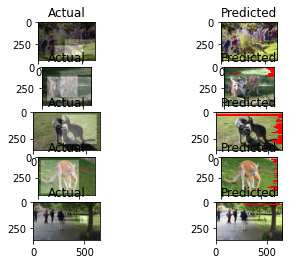

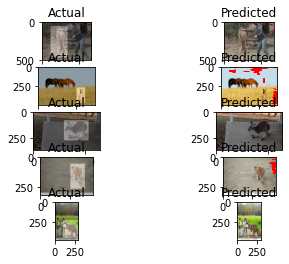

In [19]:
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)